# Notebook 2 
## Sleep Detection - Model Training
In <b>Notebook 1 Sleep Detection - EDA</b> we have:
- explored the data to see if values are as expected from the description,
- checked if we have missing values,
- calculated correlations and saved highly correlated features into a file -> <b>"features_to_exclude.txt"</b>

In this notebook we continue with:
- defining our metrics,
- shuffle the data and split into training, validation and test set,
- training the first basic Decision Tree model,
- tuning Decision Tree hyperparameters,
- training and tuning XGBoost model.

In [165]:
import pandas as pd
import numpy as np
import datetime
import pickle
import matplotlib.pyplot as plt

import polars as pl
pl.Config.set_fmt_str_lengths(100)

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

import xgboost as xgb
from xgboost import plot_importance

from helpers import create_rolling_features, concat_in_order

#### Loading the dataset
- Load and check it again, first few rows and if it contains nulls.

In [2]:
train_data_file = 'data/sleep_data_120series_7days.csv'
df = pl.read_csv(train_data_file, dtypes={
    "dt_minute":pl.Datetime
}).sort(by=["series_id","dt_minute"])

In [3]:
df.head()

series_id,step,dt_minute,anglez,enmo,target
str,i64,datetime[μs],i64,i64,i64
"""038441c925bb""",0,2018-08-14 15:30:00,2,21,0
"""038441c925bb""",12,2018-08-14 15:31:00,27,19,0
"""038441c925bb""",24,2018-08-14 15:32:00,-46,17,0
"""038441c925bb""",36,2018-08-14 15:33:00,-79,13,0
"""038441c925bb""",48,2018-08-14 15:34:00,-79,13,0


In [4]:
df.select(pl.all().is_null().sum())

series_id,step,dt_minute,anglez,enmo,target
u32,u32,u32,u32,u32,u32
0,0,0,0,0,0


#### Create sleeping time features

In [5]:
df = df.with_columns(
    pl.col('dt_minute').dt.hour().alias('hour')
)

In [6]:
def create_sleeping_time_vars(df):
    df = df.with_columns(
        pl.when(pl.col("hour").is_in([22,23,0,1,2,3,4,5,6,7,8]))
        .then(1)
        .otherwise(0)
        .alias('night')
    )
    return df

In [7]:
df = create_sleeping_time_vars(df)

In [8]:
df.head()

series_id,step,dt_minute,anglez,enmo,target,hour,night
str,i64,datetime[μs],i64,i64,i64,u32,i32
"""038441c925bb""",0,2018-08-14 15:30:00,2,21,0,15,0
"""038441c925bb""",12,2018-08-14 15:31:00,27,19,0,15,0
"""038441c925bb""",24,2018-08-14 15:32:00,-46,17,0,15,0
"""038441c925bb""",36,2018-08-14 15:33:00,-79,13,0,15,0
"""038441c925bb""",48,2018-08-14 15:34:00,-79,13,0,15,0


#### Calculate rolling features

In [9]:
df = create_rolling_features(df)

In [10]:
df.head()

series_id,step,dt_minute,anglez,enmo,target,hour,night,enmo_15m_mean,enmo_15m_max,enmo_15m_min,enmo_15m_std,enmo_diffs_15m_sum,anglez_15m_mean,anglez_15m_max,anglez_15m_min,anglez_15m_std,anglez_diffs_15m_sum,enmo_60m_mean,enmo_60m_max,enmo_60m_min,enmo_60m_std,enmo_diffs_60m_sum,anglez_60m_mean,anglez_60m_max,anglez_60m_min,anglez_60m_std,anglez_diffs_60m_sum,enmo_180m_mean,enmo_180m_max,enmo_180m_min,enmo_180m_std,enmo_diffs_180m_sum,anglez_180m_mean,anglez_180m_max,anglez_180m_min,anglez_180m_std,anglez_diffs_180m_sum,enmo_480m_mean,enmo_480m_max,enmo_480m_min,enmo_480m_std,enmo_diffs_480m_sum,anglez_480m_mean,anglez_480m_max,anglez_480m_min,anglez_480m_std,anglez_diffs_480m_sum,enmo_diffs_sum_div_max_min_15m,anglez_diffs_sum_div_max_min_15m,enmo_diffs_sum_div_max_min_60m,anglez_diffs_sum_div_max_min_60m,enmo_diffs_sum_div_max_min_180m,anglez_diffs_sum_div_max_min_180m,enmo_diffs_sum_div_max_min_480m,anglez_diffs_sum_div_max_min_480m
str,i64,datetime[μs],i64,i64,i64,u32,i32,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""038441c925bb""",0,2018-08-14 15:30:00,2,21,0,15,0,15.0,21,12,3.505098,1.496026,-51.5,27,-79,42.82189,27.662937,14.0,21,12,2.363516,1.814691,-72.966667,27,-84,24.864437,14.999179,55.766667,485,12,80.277335,69.4788,-52.033333,40,-85,35.137435,11.674958,74.983333,485,7,71.453175,52.853957,-24.658333,48,-85,33.31955,11.134954,0.149603,0.258532,0.181469,0.133921,0.14658,0.092658,0.110342,0.083097
"""038441c925bb""",12,2018-08-14 15:31:00,27,19,0,15,0,14.777778,21,12,3.34581,1.38873,-54.666667,27,-80,41.167341,26.365562,13.967742,21,12,2.330721,1.799106,-73.225806,27,-84,24.489058,14.758633,56.263736,485,12,79.970805,69.164881,-50.956044,46,-85,36.421578,11.609415,74.80083,485,7,71.360424,52.785473,-24.443983,48,-85,33.416157,11.220945,0.138873,0.244126,0.179911,0.131774,0.145917,0.08795,0.110199,0.083738
"""038441c925bb""",24,2018-08-14 15:32:00,-46,17,0,15,0,14.5,21,12,3.27448,1.301708,-57.2,27,-80,39.631076,25.268558,14.0,21,12,2.30007,1.773763,-73.5,27,-84,24.140717,14.529244,56.26087,485,12,79.530196,68.791621,-49.945652,46,-85,37.495015,11.548179,74.595041,485,7,71.284141,52.707502,-24.136364,50,-85,33.688375,11.229315,0.130171,0.233968,0.177376,0.129725,0.14513,0.087486,0.110037,0.082568
"""038441c925bb""",36,2018-08-14 15:33:00,-79,13,0,15,0,14.272727,21,12,3.196589,1.286684,-59.181818,27,-80,38.167573,24.212256,14.030303,21,12,2.270529,1.759765,-73.757576,27,-84,23.806551,14.319933,56.580645,485,12,79.156878,68.413245,-48.892473,48,-85,38.649052,11.484758,74.349794,485,7,71.239361,52.621494,-23.843621,50,-85,33.927003,11.214896,0.128668,0.224188,0.175977,0.127857,0.144332,0.085707,0.109857,0.082462
"""038441c925bb""",48,2018-08-14 15:34:00,-79,13,0,15,0,14.083333,21,12,3.117643,1.264911,-60.916667,27,-80,36.884237,23.267222,14.029412,21,12,2.235869,1.732597,-74.029412,27,-84,23.496596,14.110025,57.0,485,12,78.835067,68.081536,-48.148936,48,-85,39.110804,11.615419,74.20082,485,7,71.130702,52.517697,-23.659836,50,-85,33.978616,11.239129,0.126491,0.215437,0.17326,0.125982,0.143632,0.086682,0.10964,0.082641


### Split into training, validation and test set.

In [11]:
# We need to split by series_id to be able to calculate rolling variables
# Shuffle series id's
series_ids_shuffle = df["series_id"].unique().sort().shuffle(seed=4)

# Determine sizes
test_val_set_size = int(series_ids_shuffle.shape[0] * 0.2)
train_set_size = series_ids_shuffle.shape[0] - 2 * test_val_set_size

# Select sets
df_train_night_ids = series_ids_shuffle[:train_set_size]
df_val_night_ids = series_ids_shuffle[train_set_size:train_set_size+test_val_set_size]
df_test_night_ids = series_ids_shuffle[train_set_size+test_val_set_size:]

df_train = df.filter(pl.col('series_id').is_in(df_train_night_ids))
df_val = df.filter(pl.col('series_id').is_in(df_val_night_ids))
df_test = df.filter(pl.col('series_id').is_in(df_test_night_ids))

#### Check if tarin, val and test sets contains all three target values

In [12]:
df_train.group_by(["target"]).agg(pl.col("dt_minute").count())

target,dt_minute
i64,u32
0,388184
1,193805
2,128093


In [13]:
df_val.group_by(["target"]).agg(pl.col("dt_minute").count())

target,dt_minute
i64,u32
0,137682
1,73263
2,30353


In [14]:
df_test.group_by(["target"]).agg(pl.col("dt_minute").count())

target,dt_minute
i64,u32
0,128407
1,67842
2,45695


In [15]:
df_train = create_rolling_features(df_train)
df_val = create_rolling_features(df_val)
df_test = create_rolling_features(df_test)

#### Read features to exclude that are highly correlated with some other features
- We have found them in <b>sleep_detection_eda.ipynb notebook</b>.

In [16]:
with open('data/features_to_exclude.txt') as f:
    vars_to_exclude = [line.rstrip() for line in f]

vars_to_exclude

['enmo_15m_max',
 'enmo_60m_max',
 'enmo_180m_max',
 'enmo_480m_max',
 'enmo_diffs_15m_sum',
 'enmo_diffs_60m_sum',
 'enmo_diffs_180m_sum',
 'enmo_diffs_480m_sum',
 'anglez',
 'anglez_15m_mean',
 'anglez_15m_std',
 'anglez_diffs_180m_sum',
 'enmo_15m_mean',
 'enmo_60m_mean',
 'enmo_60m_mean',
 'enmo_180m_mean',
 'enmo_480m_mean']

In [17]:
df_train = df_train.drop(vars_to_exclude)
df_val = df_val.drop(vars_to_exclude)
df_test = df_test.drop(vars_to_exclude)

### Transform to pandas

In [18]:
df_train_pd = df_train.to_pandas()
df_val_pd = df_val.to_pandas()
df_test_pd = df_test.to_pandas()

labels = "target"
y_train = df_train_pd[labels].values
y_val = df_val_pd[labels].values
y_test = df_test_pd[labels].values

del df_train_pd[labels] 
del df_val_pd[labels]
del df_test_pd[labels]

features = [f for f in df_train_pd.columns if f not in ["dt_minute","step","series_id"]]
features

['enmo',
 'hour',
 'night',
 'enmo_15m_min',
 'enmo_15m_std',
 'anglez_15m_max',
 'anglez_15m_min',
 'anglez_diffs_15m_sum',
 'enmo_60m_min',
 'enmo_60m_std',
 'anglez_60m_mean',
 'anglez_60m_max',
 'anglez_60m_min',
 'anglez_60m_std',
 'anglez_diffs_60m_sum',
 'enmo_180m_min',
 'enmo_180m_std',
 'anglez_180m_mean',
 'anglez_180m_max',
 'anglez_180m_min',
 'anglez_180m_std',
 'enmo_480m_min',
 'enmo_480m_std',
 'anglez_480m_mean',
 'anglez_480m_max',
 'anglez_480m_min',
 'anglez_480m_std',
 'anglez_diffs_480m_sum',
 'enmo_diffs_sum_div_max_min_15m',
 'anglez_diffs_sum_div_max_min_15m',
 'enmo_diffs_sum_div_max_min_60m',
 'anglez_diffs_sum_div_max_min_60m',
 'enmo_diffs_sum_div_max_min_180m',
 'anglez_diffs_sum_div_max_min_180m',
 'enmo_diffs_sum_div_max_min_480m',
 'anglez_diffs_sum_div_max_min_480m']

### Transform categorical variables (actyally only one - "hour") into one-hot-encoded variables.

In [20]:
X_train = df_train_pd[features]
X_val = df_val_pd[features]
X_test = df_test_pd[features]

## Metrics
- This is a classification problem so we will calculate accuracy.
- However, our goal is to determine <b>sleep state</b> so we will also calculate precision, recall and F1 score for sleep.
- Our priority will be <b>sleep F1 score metric</b>.  

#### Precision, recall and F1 score

In [65]:
def calculate_metrics(y_pred,y_val,target):
    precision = sum((y_pred==y_val) & (y_val==target)) / sum(y_pred==target)
    recall = sum((y_pred==y_val) & (y_val==target)) / sum(y_val==target)
    f1_score = 2 / ((1/precision) + (1/recall))
    return precision, recall, f1_score

## Model 1: Decision tree

Let's start with a very simple tree of depth 2.

In [66]:
model = DecisionTreeClassifier(max_depth=3, random_state=3)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=3)

In [67]:
model.classes_

array([0, 1, 2])

In [68]:
print(export_text(model, feature_names=features))

|--- enmo_60m_std <= 14.40
|   |--- anglez_diffs_480m_sum <= 8.59
|   |   |--- anglez_180m_max <= 80.50
|   |   |   |--- class: 2
|   |   |--- anglez_180m_max >  80.50
|   |   |   |--- class: 2
|   |--- anglez_diffs_480m_sum >  8.59
|   |   |--- night <= 0.50
|   |   |   |--- class: 0
|   |   |--- night >  0.50
|   |   |   |--- class: 1
|--- enmo_60m_std >  14.40
|   |--- anglez_diffs_480m_sum <= 7.84
|   |   |--- enmo_60m_min <= 16.50
|   |   |   |--- class: 2
|   |   |--- enmo_60m_min >  16.50
|   |   |   |--- class: 2
|   |--- anglez_diffs_480m_sum >  7.84
|   |   |--- hour <= 6.50
|   |   |   |--- class: 1
|   |   |--- hour >  6.50
|   |   |   |--- class: 0



We can see that the most importnat features are:
- enmo_60m_std
- anglez_diffs_480m_sum
- anglez_180m_max
- night
- enmo_60m_min
- hour

In [69]:
y_pred = model.predict(X_val)

In [70]:
accuracy = sum(y_val == y_pred) / y_pred.size
sleep_precision, sleep_recall, sleep_f1_score = calculate_metrics(y_pred,y_val,target=1)

In [72]:
print(
    f"Accuracy: \t\t {accuracy.round(3)}"
    f"\nSleep precision: \t {sleep_precision.round(3)}" 
    f"\nSleep recall: \t\t {sleep_recall.round(3)} "
    f"\nSleep F1 score: \t {sleep_f1_score.round(3)}"
)

Accuracy: 		 0.854
Sleep precision: 	 0.839
Sleep recall: 		 0.865 
Sleep F1 score: 	 0.852


We can see that even this simple tree gives us decent results.

However, we will try to improve.

### Decision tree - hyperparameter tuning
- Parameters that will be tuned:
    - max_depth
    - min_samples_split 

In [41]:
max_depth_s = [2,6,8,10]
min_samples_split_s = [150, 200, 250]

In [42]:
results = []
for max_depth in max_depth_s:
    for min_samples_split in min_samples_split_s:
        print(f"growing tree with max_depth: {max_depth} and min_sampes_split: {min_samples_split} ...")
        model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        accuracy = sum(y_val == y_pred) / y_pred.size
        sleep_precision, sleep_recall, sleep_f1_score = calculate_metrics(target=1)
        results.append({
            "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "accuracy": accuracy,
            "sleep_precision": sleep_precision,
            "sleep_recall": sleep_recall,
            "sleep_f1_score": sleep_f1_score
        })

growing tree with max_depth: 2 and min_sampes_split: 150 ...
growing tree with max_depth: 2 and min_sampes_split: 200 ...
growing tree with max_depth: 2 and min_sampes_split: 250 ...
growing tree with max_depth: 6 and min_sampes_split: 150 ...
growing tree with max_depth: 6 and min_sampes_split: 200 ...
growing tree with max_depth: 6 and min_sampes_split: 250 ...
growing tree with max_depth: 8 and min_sampes_split: 150 ...
growing tree with max_depth: 8 and min_sampes_split: 200 ...
growing tree with max_depth: 8 and min_sampes_split: 250 ...
growing tree with max_depth: 10 and min_sampes_split: 150 ...
growing tree with max_depth: 10 and min_sampes_split: 200 ...
growing tree with max_depth: 10 and min_sampes_split: 250 ...


In [43]:
results_pd = pd.DataFrame(results).set_index(["max_depth","min_samples_split"])

In [44]:
results_pd.sort_values(by="sleep_f1_score", ascending=False).style.format(precision=4).background_gradient(subset=["sleep_f1_score"], axis=0)

The best sleep F1 score is obtained for decision tree with max_depth=8 and min_sample_split=200.

Our best sleep F1 score is equal to <b>0.8781<b>.

### Decision Tree - best probability threshold 
- We plot precision and recall for different probability thresholds to see which threshold is optimal.

In [82]:
model = DecisionTreeClassifier(max_depth=8, min_samples_split=200, random_state=1)
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_val)
y_proba_sleep = y_proba[:,1]

In [83]:
thrs = np.linspace(0,0.99,100)
thrs

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [89]:
precision_recall = {}
for t in thrs:
    y_pred = (y_proba_sleep>t).astype(int)
    sleep_precision, sleep_recall, sleep_f1_score = calculate_metrics(y_pred,y_val,target=1)
    precision_recall[t] = [sleep_precision, sleep_recall]

In [90]:
df_p_r = pd.DataFrame(precision_recall).T
df_p_r.columns = ["precision", "recall"]

<Figure size 600x600 with 0 Axes>

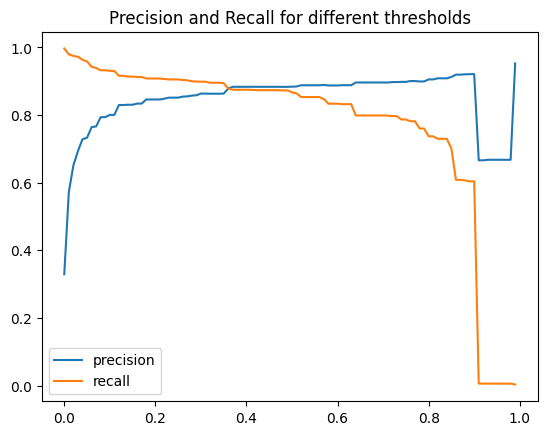

In [91]:
plt.figure(figsize=(6, 6));
df_p_r.plot();
plt.title("Precision and Recall for different thresholds");

Summary
- Threshold form about 3.9 to 5 should give us similar results.
- Let's stay with 0.5.

## Model 2: XGBoost
- Let's train first a model checking how mnay num_boost_round will be optimal.
- Then we will tune hyperparamaters.

In [108]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

In [109]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [110]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'multi:softprob', 
    'num_class': 3,
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}

In [129]:
model = xgb.train(
    xgb_params, 
    dtrain,
    evals=watchlist,
    verbose_eval=10, #print every 10 step
    num_boost_round=50 # 30 is optimal - with more we overfit
)

[0]	train-auc:0.93901	val-auc:0.91900
[10]	train-auc:0.97765	val-auc:0.92623
[20]	train-auc:0.98742	val-auc:0.92296
[30]	train-auc:0.99240	val-auc:0.92113
[40]	train-auc:0.99533	val-auc:0.92085
[49]	train-auc:0.99672	val-auc:0.92096


In [130]:
y_pred_proba = model.predict(dval)
y_pred_proba

array([[0.81801087, 0.08234242, 0.09964678],
       [0.84379447, 0.08349394, 0.07271165],
       [0.84008867, 0.08839852, 0.07151283],
       ...,
       [0.63327444, 0.22146748, 0.14525814],
       [0.6863007 , 0.20312554, 0.11057376],
       [0.7299095 , 0.15249072, 0.11759982]], dtype=float32)

In [131]:
y_pred = np.argmax(y_pred_proba, axis=1)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [132]:
accuracy = sum(y_val == y_pred) / y_pred.size
sleep_precision, sleep_recall, f1_score = calculate_metrics(y_pred,y_val,target=1)

In [133]:
print(
    f"Accuracy: \t\t {accuracy.round(3)}"
    f"\nSleep precision: \t {sleep_precision.round(3)}" 
    f"\nSleep recall: \t\t {sleep_recall.round(3)} "
    f"\nSleep F1 score: \t {sleep_f1_score.round(3)}"
)

Accuracy: 		 0.859
Sleep precision: 	 0.885
Sleep recall: 		 0.918 
Sleep F1 score: 	 0.901


### XGBoost - hyperparameters tuning

In [134]:
max_depth_s = [2,6,8]
min_child_weight_s = [200, 250,300]

In [135]:
results = []
for max_depth in max_depth_s:
    for min_child_weight in min_child_weight_s:
        xgb_params = {
            'eta': 0.3, 
            'max_depth': max_depth,
            'min_child_weight': min_child_weight,
            'objective': 'multi:softprob', 
            'num_class': 3,
            'eval_metric': 'auc',
            'nthread': 8,
            'seed': 1,
            'verbosity': 1
        }
        print(f"training xgboost with max_depth: {max_depth} and min_child_weight: {min_samples_split} ...")
        model = xgb.train(
            xgb_params, 
            dtrain,
            evals=watchlist,
            verbose_eval=10, #print every 10 step
            num_boost_round=50 # with more we overfit
        )
        
        y_pred_proba = model.predict(dval)
        y_pred = np.argmax(y_pred_proba, axis=1)

        accuracy = sum(y_val == y_pred) / y_pred.size
        sleep_precision, sleep_recall, sleep_f1_score = calculate_metrics(y_pred,y_val,target=1)
        results.append({
            "max_depth": max_depth,
            "min_child_weight": min_child_weight,
            "accuracy": accuracy,
            "sleep_precision": sleep_precision,
            "sleep_recall": sleep_recall,
            "sleep_f1_score": sleep_f1_score
        })

training xgboost with max_depth: 2 and min_child_weight: 250 ...
[0]	train-auc:0.86874	val-auc:0.89852
[10]	train-auc:0.91811	val-auc:0.92633
[20]	train-auc:0.92742	val-auc:0.92691
[30]	train-auc:0.93128	val-auc:0.92632
[40]	train-auc:0.93457	val-auc:0.92569
[49]	train-auc:0.93718	val-auc:0.92568
training xgboost with max_depth: 2 and min_child_weight: 250 ...
[0]	train-auc:0.86874	val-auc:0.89852
[10]	train-auc:0.91811	val-auc:0.92633
[20]	train-auc:0.92680	val-auc:0.92721
[30]	train-auc:0.93169	val-auc:0.92631
[40]	train-auc:0.93471	val-auc:0.92608
[49]	train-auc:0.93728	val-auc:0.92555
training xgboost with max_depth: 2 and min_child_weight: 250 ...
[0]	train-auc:0.86874	val-auc:0.89852
[10]	train-auc:0.91811	val-auc:0.92633
[20]	train-auc:0.92674	val-auc:0.92717
[30]	train-auc:0.93129	val-auc:0.92659
[40]	train-auc:0.93449	val-auc:0.92545
[49]	train-auc:0.93672	val-auc:0.92522
training xgboost with max_depth: 6 and min_child_weight: 250 ...
[0]	train-auc:0.92625	val-auc:0.92074
[10

In [136]:
results_pd = pd.DataFrame(results).set_index(["max_depth","min_child_weight"])

In [137]:
results_pd.sort_values(by="sleep_f1_score", ascending=False).style.format(precision=4).background_gradient(subset=["sleep_f1_score"], axis=0)

The best sleep F1 score is obtained for XGBoost model with max_depth=6 and min_chimld_weight=250.

Our best sleep F1 score is equal to <b>0.9014</b>. 
- That's an improvement from the best DT of 0.8781.

### Feature importance

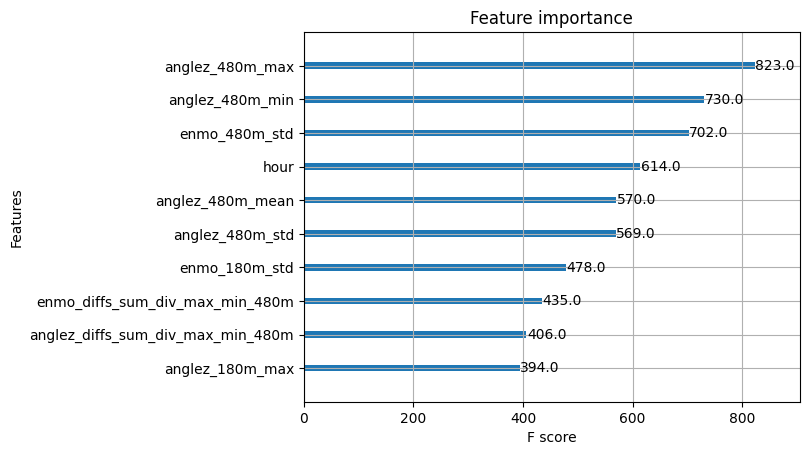

In [151]:
plot_importance(model, max_num_features=10, importance_type="weight");

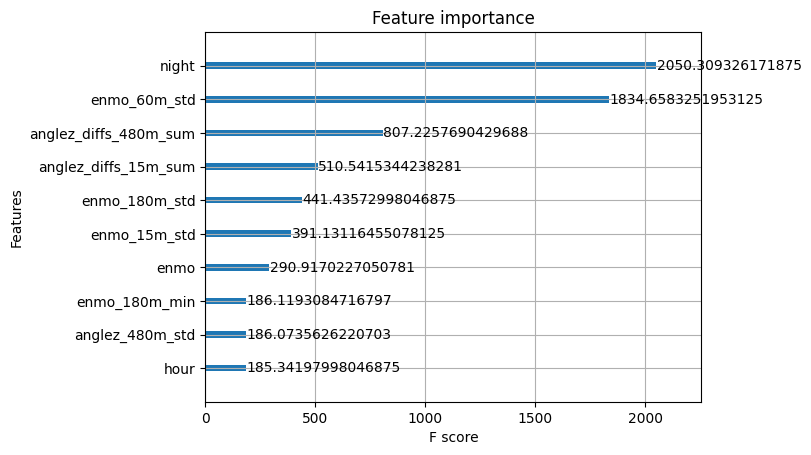

In [148]:
plot_importance(model, max_num_features=10, importance_type="gain");

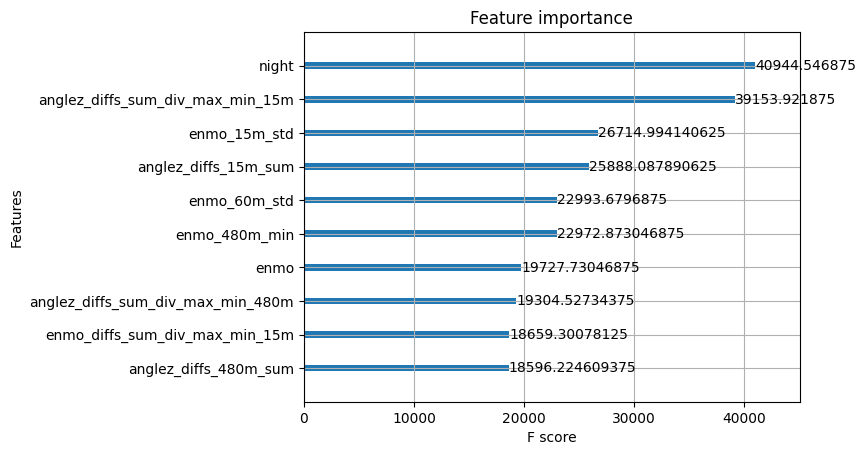

In [154]:
plot_importance(model, max_num_features=10, importance_type="cover");

In [155]:
features_importance_weight = model.get_score(importance_type='weight')
features_importance_gain = model.get_score(importance_type='gain')
features_importance_cover = model.get_score(importance_type='cover')

### Test set performance

In [140]:
y_test_proba = model.predict(dtest)
y_test_pred = np.argmax(y_test_proba, axis=1)

In [141]:
accuracy = sum(y_test == y_test_pred) / y_pred.size
sleep_precision, sleep_recall, f1_score = calculate_metrics(y_test_pred,y_test,target=1)

In [142]:
print(
    f"Accuracy: \t\t {accuracy.round(3)}"
    f"\nSleep precision: \t {sleep_precision.round(3)}" 
    f"\nSleep recall: \t\t {sleep_recall.round(3)} "
    f"\nSleep F1 score: \t {sleep_f1_score.round(3)}"
)

Accuracy: 		 0.817
Sleep precision: 	 0.869
Sleep recall: 		 0.936 
Sleep F1 score: 	 0.899


#### Summary
- Test set sleep F1 score is similar to the one of validation set.
- Recall is a bit higher and precision is a bit lower.
- Accuracy is a bit lower but this is not a large difference.

### Saving best model

In [167]:
model_file_name = "sleep_detection_model_xgb.bin"
pickle.dump(model, open(model_file_name, 'wb'))

Later to load it we can run the below code

```python
model_file_name = "sleep_detection_model_xgb.bin"
with open(model_file_name, 'rb') as mof_in:
    model = pickle.load(mof_in)
```